# KNN Classifier

In [1]:
from common import get_prediction, split_data, get_data
import preprocessing as prep
import numpy as np

## Cargamos el dataset

In [2]:
data = get_data()
data.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


In [3]:
pred = get_prediction()
pred.head()

0    0
1    0
2    0
3    0
4    1
Name: volveria, dtype: int64

## Dividimos los datos

Separamos el holdout

In [4]:
X_train_val, X_holdout, y_train_val, y_holdout = split_data(data, pred)
X_train_val.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
239,normal,Señor Celestino Miguel,797,mujer,52.0,0,0,39687,3,adelante,fiumark_palermo
281,4d,Señora Reina Benita,141,mujer,NaN,0,2,489:,2,NaN,fiumark_chacarita
504,3d,Señor Emeterio de Jesus,309,hombre,33.0,1,0,"R1RR""55:3",3,NaN,fiumark_chacarita
230,4d,Señor Juan Jorge Alberto,158,hombre,33.0,0,0,"UQVQP1QS""5;42;2",1,NaN,fiumark_palermo
738,4d,Señor Pablo Augusto,495,hombre,24.0,0,0,"C16""675:2",1,NaN,fiumark_palermo


Separamos el validation

In [5]:
X_train, X_val, y_train, y_val = split_data(X_train_val, y_train_val)
X_train.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
475,4d,Señor Ignacio Nazar,689,hombre,21.0,0,0,572258,1,NaN,fiumark_palermo
247,4d,Señor Abel Omar,644,hombre,NaN,0,0,3823,6,NaN,fiumark_palermo
726,normal,Señor Fausto Rene,468,hombre,59.0,0,0,3359;4,3,NaN,fiumark_palermo
106,3d,Señora Irma Pascualina,707,mujer,48.0,0,0,4457;8,2,NaN,fiumark_palermo
206,4d,Señor Ovidio Valentin,871,hombre,29.0,0,0,56;46:,1,NaN,fiumark_palermo


## Entrenamos los modelos

Se entrenara este modelo de 3 formas distintas:

### 1. Modelo sin normalizar ni estandarizar los datos

Primero preprocesamos al igual que con decision tree classifier con los distintos preprocesados.

In [6]:
# Con la columna fila
prep_base_1 = prep.Preprocessing(
    [prep.Drop_high_cardinals(), prep.Dummy_variables()]
)

# Rellenado de nan con zeros
prep_1 = prep.Preprocessing(
    [prep_base_1, prep.Nan_to_zero()]
)

# Rellenado de nan con la media
prep_2 = prep.Preprocessing(
    [prep_base_1, prep.Nan_to_mean()]
)

# Rellenado de nan con la moda
prep_3 = prep.Preprocessing(
    [prep_base_1, prep.Nan_to_mode()]
)

# Rellenado de nan con la median
prep_4 = prep.Preprocessing(
    [prep_base_1, prep.Nan_to_median()]
)

In [7]:
# Sin la columna fila
prep_base_2 = prep.Preprocessing(
    [prep.Drop_high_cardinals(), prep.Drop_column_nan(), prep.Dummy_variables()]
)

# Rellenado de nan con zeros
prep_5 = prep.Preprocessing(
    [prep_base_2, prep.Nan_to_zero()]
)

# Rellenado de nan con la media
prep_6 = prep.Preprocessing(
    [prep_base_2, prep.Nan_to_mean()]
)

# Rellenado de nan con la moda
prep_7 = prep.Preprocessing(
    [prep_base_2, prep.Nan_to_mode()]
)

# Rellenado de nan con la median
prep_8 = prep.Preprocessing(
    [prep_base_2, prep.Nan_to_median()]
)

In [8]:
list_preprocessing = [
    # con la columna fila
    prep_1, prep_2, prep_3, prep_4,
    # sin la columna fila
    prep_5, prep_6, prep_7, prep_8
]

params = {
    'n_neighbors': np.arange(1, 50),
    'metric': ['euclidean', 'minkowski', 'manhattan', 'chebyshev', 'cosine'],
    "weights": ['uniform', 'distance']
}

In [9]:
from common import super_training
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

models_preprocessing = super_training(
    X_train, y_train, list_preprocessing,
    GridSearchCV(
        KNeighborsClassifier(),
        params, scoring='roc_auc', n_jobs=-1, cv=5
    )
)

#### Vemos cual de estos es mejor

In [10]:
from common import get_proba_predicts

proba_predicts = get_proba_predicts(models_preprocessing, X_val)

<Figure size 432x288 with 0 Axes>

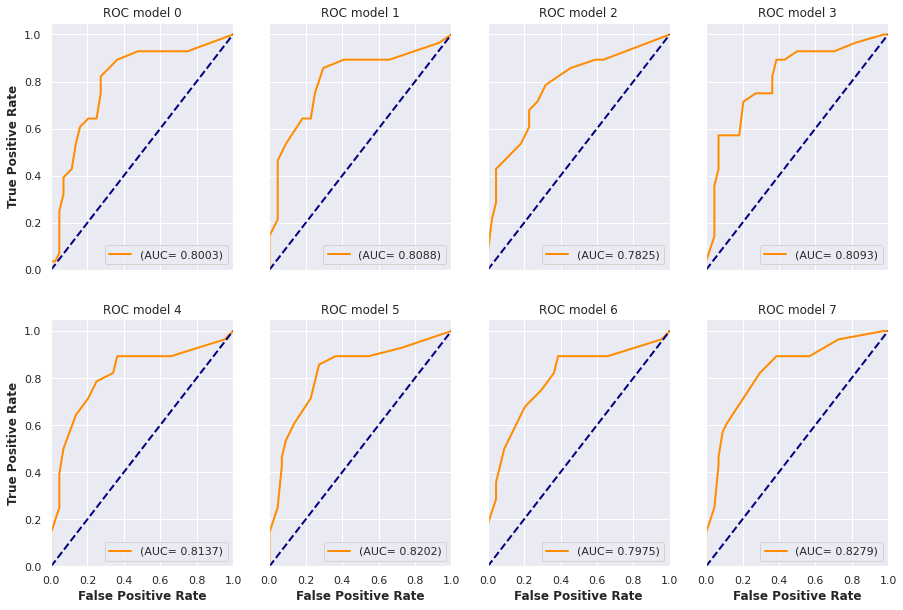

In [11]:
from common import plot_rocs
best_model_index = plot_rocs(proba_predicts, y_val, 4, 2)

Esta vez el mejor modelo parece el numero 7.

In [12]:
best_knn_prep = models_preprocessing[best_model_index]
best_knn_prep[0]

KNeighborsClassifier(metric='cosine', n_neighbors=16)

Vemos que hace su preprocesado

In [13]:
best_knn_prep[1].function()

Elimina las columnas con alta cardinalidad
Elimina las columnas con un porcentaje de valores nan mayor igual al 70%
Transforma las variables categoricas en dummy variables
Rellena los nan de edad con la mediana


Veamos como se comporta este modelo con el resto de preprocesamientos.

### 2. Modelo con media 0

Ahora al final de los preprocesados anteriores se normalizaran las columnas no binarias.

In [14]:
list_preprocessing_norm = []
# Se agregara la normalizacion de los datos a los preprocesados anteriores
for p in list_preprocessing:
    list_preprocessing_norm.append(
        prep.Preprocessing(
            [p, prep.Normalizer_columns()]
        )
    )

In [15]:
models_preprocessing_norm = super_training(
    X_train, y_train, list_preprocessing_norm,
    GridSearchCV(
        KNeighborsClassifier(),
        params, scoring='roc_auc', n_jobs=-1, cv=5
    )
)

In [16]:
proba_predicts = get_proba_predicts(models_preprocessing_norm, X_val)

<Figure size 432x288 with 0 Axes>

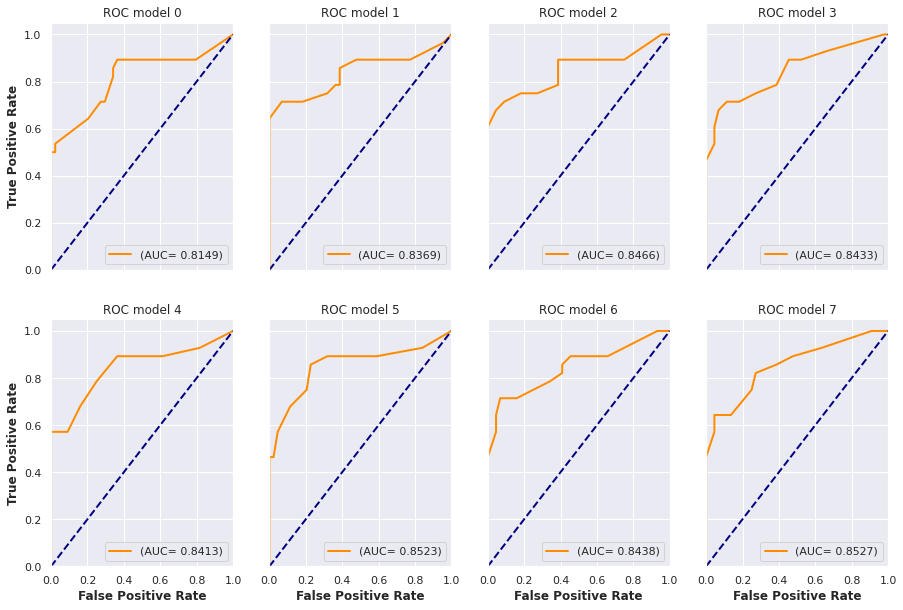

In [17]:
best_model_index = plot_rocs(proba_predicts, y_val, 4, 2)

Al igual que el con el caso anterior, el mejor preprocesado es el numero 7.

In [18]:
best_knn_prep_norm = models_preprocessing_norm[best_model_index]
best_knn_prep_norm[0]

KNeighborsClassifier(metric='chebyshev', n_neighbors=13)

Vemos que hace su preprocesado

In [19]:
best_knn_prep_norm[1].function()

Elimina las columnas con alta cardinalidad
Elimina las columnas con un porcentaje de valores nan mayor igual al 70%
Transforma las variables categoricas en dummy variables
Rellena los nan de edad con la mediana
Normaliza los atributos no binarios


Veamos como se comporta este modelo con los datos estandarizados.

### 3. Modelo con media 0 y varianza 1

Por ultimo, se estandarizara las columnas no binarias.

In [20]:
list_preprocessing_std = []
# Se agregara la estandarizacion de los datos a los preprocesados anteriores
for p in list_preprocessing:
    list_preprocessing_std.append(
        prep.Preprocessing(
            [p, prep.Std_columns()]
        )
    )

In [21]:
models_preprocessing_std = super_training(
    X_train, y_train, list_preprocessing_std,
    GridSearchCV(
        KNeighborsClassifier(),
        params, scoring='roc_auc', n_jobs=-1, cv=5
    )
)

In [22]:
proba_predicts = get_proba_predicts(models_preprocessing_std, X_val)

<Figure size 432x288 with 0 Axes>

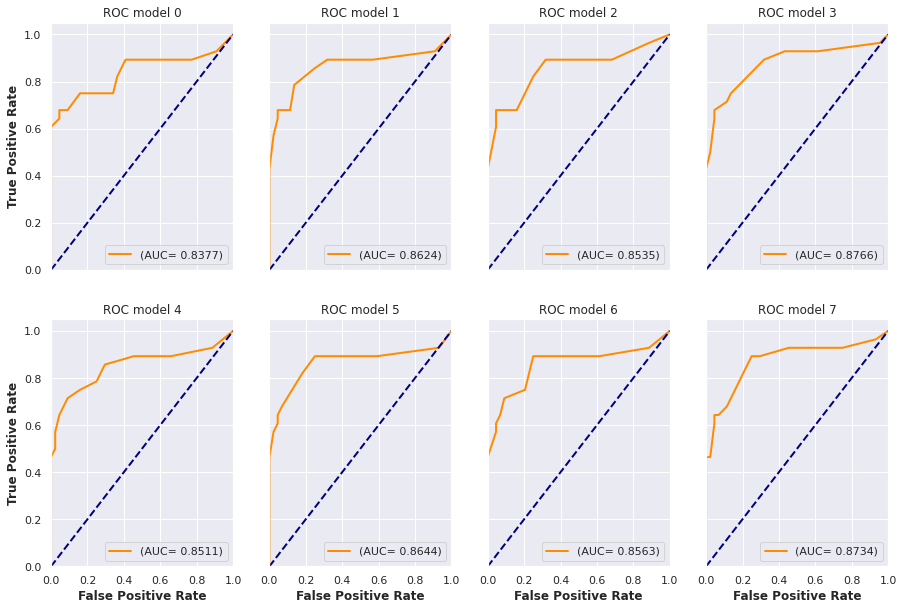

In [23]:
best_model_index = plot_rocs(proba_predicts, y_val, 4, 2)

Este ultimo preprocesado tiene mejores resultados a comparación de los anteriores; esta vez el mejor preprocesado es el numero 3.

In [24]:
best_knn_prep_std = models_preprocessing_std[best_model_index]
best_knn_prep_std[0]

KNeighborsClassifier(metric='euclidean', n_neighbors=13)

Vemos que hace su preprocesado

In [25]:
best_knn_prep_std[1].function()

Elimina las columnas con alta cardinalidad
Transforma las variables categoricas en dummy variables
Rellena los nan de edad con la mediana
Estandariza los atributos no binarios


## Escogemos el mejor modelo

In [26]:
models_prep_final = [best_knn_prep, best_knn_prep_norm, best_knn_prep_std]

proba_predicts = get_proba_predicts(models_prep_final, X_val)

<Figure size 432x288 with 0 Axes>

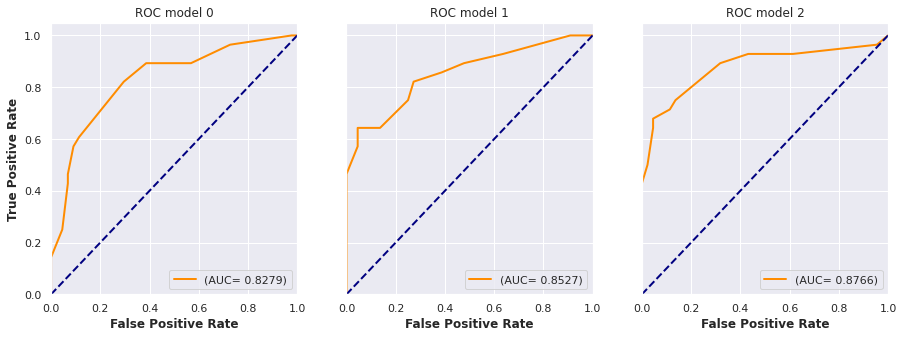

In [27]:
best_model_index = plot_rocs(proba_predicts, y_val, 3, 1)

El mejor modelo de todos resultó el ultimo.

In [28]:
best_knn, preprocessing = models_prep_final[best_model_index]
best_knn

KNeighborsClassifier(metric='euclidean', n_neighbors=13)

Con el siguiente preprocesado

In [29]:
preprocessing.function()

Elimina las columnas con alta cardinalidad
Transforma las variables categoricas en dummy variables
Rellena los nan de edad con la mediana
Estandariza los atributos no binarios


## Vemos las metricas del mejor modelo

Preprocesamos el holdout

In [30]:
X_holdout_ = preprocessing.transform(X_holdout)
X_holdout_.head()

,edad,amigos,parientes,precio_ticket,tipo_de_sala_4d,tipo_de_sala_normal,genero_mujer,fila_medio,fila_nan,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
713,0.333333,0.000,0.2,0.28,0,1,0,0,0,1,0,0.0
370,0.300000,0.000,0.0,0.00,1,0,0,0,1,1,0,0.0
114,0.525000,0.125,0.0,0.08,0,0,0,0,1,0,0,0.0
323,0.300000,0.000,0.0,0.00,1,0,1,0,1,0,1,0.0
131,0.050000,0.000,0.4,0.08,1,0,1,0,1,1,0,0.0


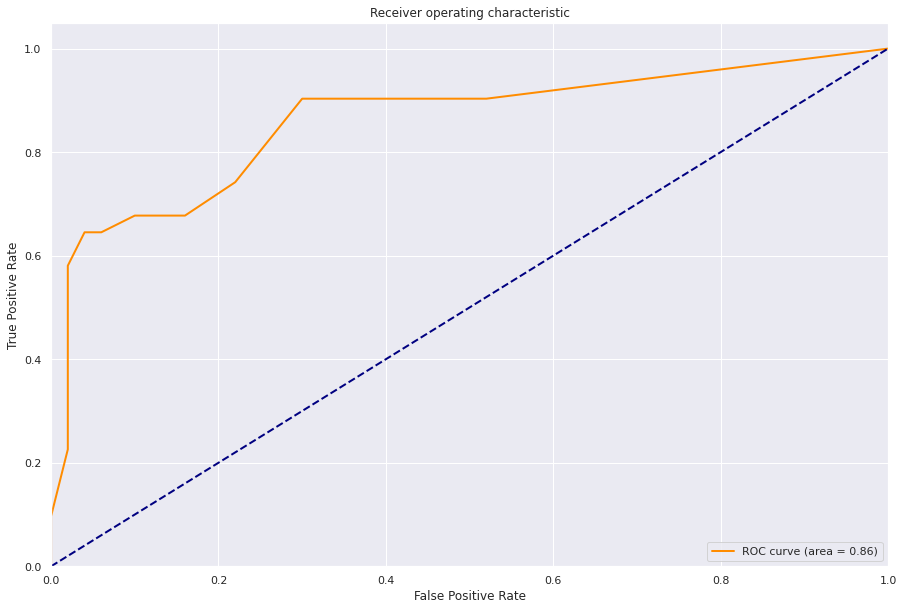

0.8593548387096774

In [31]:
from common import plot_roc
plot_roc(y_holdout, best_knn.predict_proba(X_holdout_)[:,1])

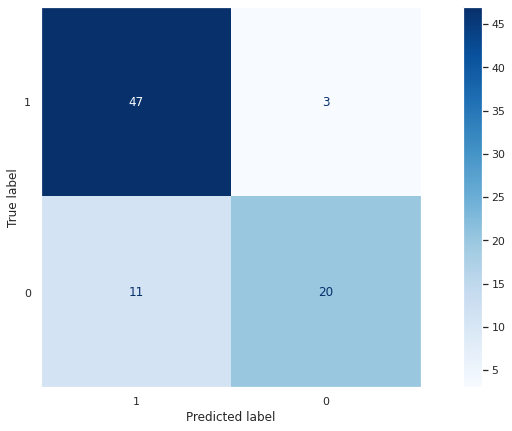

In [32]:
from common import plot_confusion
plot_confusion(
    best_knn, 
    X_holdout_, 
    y_holdout
)

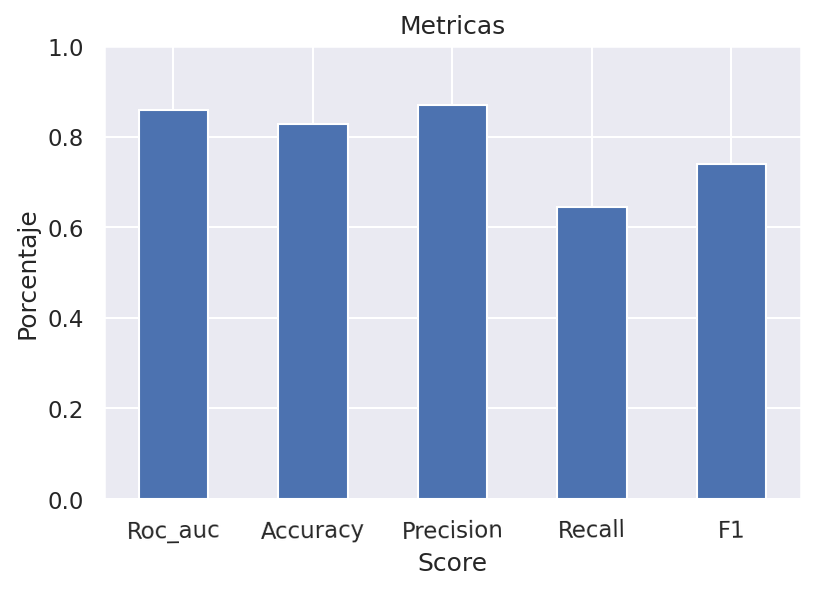

Roc_auc      0.859355
Accuracy     0.827160
Precision    0.869565
Recall       0.645161
F1           0.740741
dtype: float64

In [33]:
from common import plot_metrics
plot_metrics(
    y_holdout, 
    best_knn.predict_proba(X_holdout_)[:,1], 
    best_knn.predict(X_holdout_)
)

## Hacemos la predicción sobre el holdout de la empresa

In [34]:
from common import get_holdout
X_holdout_empresa = get_holdout()
X_holdout_empresa.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señorita Beatriz Estela,650,mujer,26.0,0,0,"EC0""4536",1,NaN,fiumark_palermo
1,4d,Señorita Elena Herminda,234,mujer,8.0,4,2,569299,4,NaN,fiumark_palermo
2,normal,Señor Humberto Americo,31,hombre,43.0,0,0,"RE""39823",3,NaN,fiumark_chacarita
3,3d,Señor Casiano,552,hombre,30.0,0,0,46657:,3,NaN,fiumark_palermo
4,4d,Señor Gregorio Nicolas,411,hombre,NaN,0,0,56;444,1,NaN,fiumark_palermo


Preprocesamos el holdout de la empresa con el mejor preprocesamiento para este modelo y separamos 

In [35]:
ussers = X_holdout_empresa['id_usuario']
X_holdout_empresa_ = prep.Preprocessing_KNN().transform(X_holdout_empresa)
X_holdout_empresa_.head()

,edad,amigos,parientes,precio_ticket,tipo_de_sala_4d,tipo_de_sala_normal,genero_mujer,fila_medio,fila_nan,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,0.344569,0.0,0.0,0.000000,1,0,1,0,1,1,0,0.0
1,0.063670,0.5,0.4,0.061224,1,0,1,0,1,1,0,0.0
2,0.609863,0.0,0.0,0.040816,0,1,0,0,1,0,0,0.0
3,0.406991,0.0,0.0,0.040816,0,0,0,0,1,1,0,0.0
4,0.438202,0.0,0.0,0.000000,1,0,0,0,1,1,0,0.0


Predecimos con el mejor modelo

In [36]:
volveria = best_knn.predict(X_holdout_empresa_)
volveria

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0])

Generamos el dataframe de las predicciones

In [37]:
import pandas as pd
predictions = pd.DataFrame({
    'id_usuario': ussers, 
    'volveria': volveria
})
predictions.head()

,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0


Guardamos el archivo

In [38]:
predictions.to_csv(
    'KNNClassifier.csv', 
    columns=predictions.columns, 
    index=False
)